In [9]:
import os
import pathlib
from glob import glob

import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import xarray as xr

In [10]:
maca_dir = os.path.join(
    pathlib.Path.home(), 
    'habitat-suitability', 
    'maca')
os.makedirs(maca_dir, exist_ok=True)

In [11]:
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data')
denver_path = os.path.join(
    data_dir,
    'denver-air-quality',
    'denver-boundary',
    'denver.shp'
)
denver_gdf = gpd.read_file(denver_path)

In [12]:
def convert_longitude(longitude):
    """Convert longitude range from 0-360 to -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

maca_da_list = []
for site_name, site_gdf in {'denver': denver_gdf}.items():
    for variable in ['pr']:
        for start_year in [2091, 2006]:
            end_year = start_year + 4
            maca_url = (
                'http://thredds.northwestknowledge.net:8080'
                '/thredds/dodsC/MACAV2/BNU-ESM'
                f'/macav2metdata_{variable}_BNU-ESM_r1i1p1_rcp45_'
                f'{start_year}_{end_year}_CONUS_monthly.nc')
            maca_da = xr.open_dataset(maca_url).squeeze().precipitation
            bounds = site_gdf.to_crs(maca_da.rio.crs).total_bounds
            maca_da = maca_da.assign_coords(
                lon=("lon", 
                     [convert_longitude(l) for l in maca_da.lon.values]))
            maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
            maca_da = maca_da.rio.clip_box(*bounds)
            maca_da_list.append(dict(
                site_name=site_name,
                variable=variable,
                start_year=start_year,
                da=maca_da))

maca_df = pd.DataFrame(maca_da_list)
maca_df[['site_name', 'variable', 'start_year']]

,site_name,variable,start_year
0,denver,pr,2091
1,denver,pr,2006


In [15]:
srtm_path = os.path.join(data_dir, 'habitat-suitability', 'srtm', '*.hgt.zip')
srtm_da = rxrmerge.merge_arrays([
    rxr.open_rasterio(path, mask_and_scale=True).squeeze()
    for path in glob(srtm_path)
]).rio.clip_box(*denver_gdf.total_bounds)

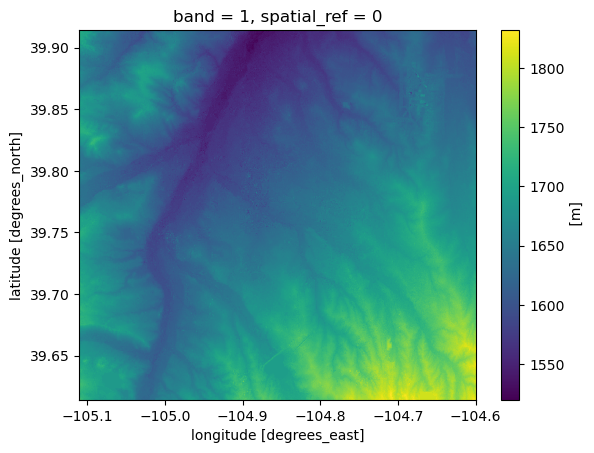

In [16]:
srtm_da.plot()

In [18]:
maca_df.drop('da', axis='columns')

,site_name,variable,start_year
0,denver,pr,2091
1,denver,pr,2006


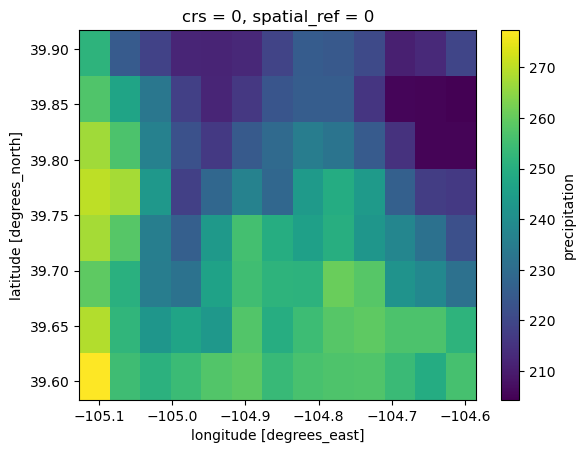

In [43]:
maca_2091_original_da = (
    maca_df
    [(maca_df.start_year==2091) & (maca_df.variable=='pr')]
    .da.values.item()
    .rio.write_crs(4326)
    .rio.set_spatial_dims('lat', 'lon')
    .groupby('time.year')
    .sum()
    .min('year')
)
maca_2091_original_da.plot()

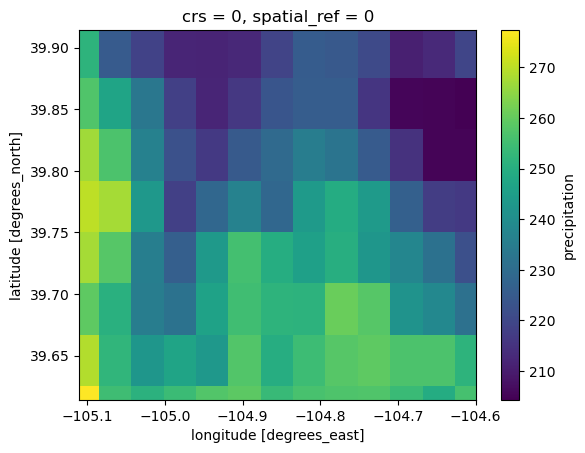

In [44]:
maca_2091_da = maca_2091_original_da.rio.reproject_match(srtm_da)
maca_2091_da.plot()

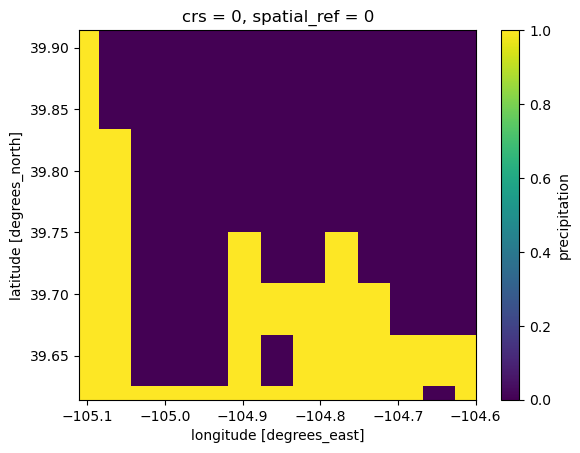

In [52]:
maca_suitable_2091 = maca_2091_da > 250
maca_suitable_2091.plot()

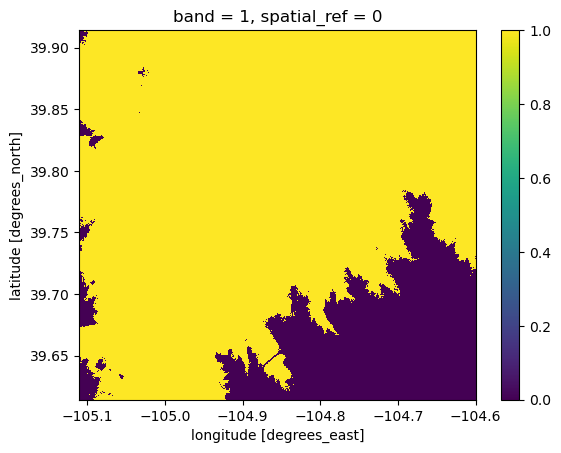

In [48]:
srtm_suitable_da = srtm_da < 1700
srtm_suitable_da.plot()

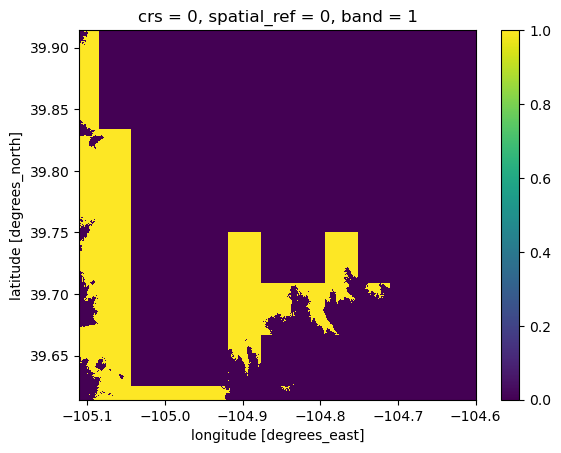

In [53]:
suitable_2091 = maca_suitable_2091 * srtm_suitable_da
suitable_2091.plot()